# Training and hosting SageMaker Models using the Apache MXNet Module API

When there is a person in front of you, your human eyes can immediately recognize what direction the person is looking at (e.g. either facing straight up to you or looking at somewhere else). The direction is defined as the head-pose. We are going to develop a deep neural learning model to estimate such a head-pose based on an input human head image. The **SageMaker Python SDK** makes it easy to train and deploy MXNet models. In this example, we train a ResNet-50 model using the Apache MXNet [Module API](https://mxnet.incubator.apache.org/api/python/module.html) and the head-pose dataset. 

The task at hand is to train a model using the head-pose dataset so that the trained model is able to classify  head-pose into 9 different categories (the combinations of 3 tilt and 3 pan angles).

In [1]:
import sys
print(sys.version)

3.6.2 |Anaconda custom (64-bit)| (default, Jul 20 2017, 13:51:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


### Setup

First we need to define a few variables that will be needed later in the example.

In [2]:
from sagemaker import get_execution_role

s3_bucket = '<your S3 bucket >'
headpose_folder = 'headpose'

#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://{}/{}/customMXNetcodes'.format(s3_bucket, headpose_folder)

#Bucket location where results of model training are saved.
model_artifacts_location = 's3://{}/{}/artifacts'.format(s3_bucket, headpose_folder)

#IAM execution role that gives SageMaker access to resources in your AWS account.
#We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

### The training script

The ``EntryPt-headpose.py`` script provides all the code we need for training and hosting a SageMaker model. The script we will use is adapted and modified from Apache MXNet [MNIST tutorial](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk/mxnet_mnist) and [HeadPose tutorial](https://github.com/aws-samples/headpose-estimator-apache-mxnet/blob/master/HeadPose_ResNet50_Tutorial.ipynb)

In [3]:
!cat EntryPt-headpose.py

import logging

import mxnet as mx
import numpy as np
import os
import urllib
import pickle
import sys
import cv2

##################################
###
### Helper functions
###
##################################

class EvalCallback(object):
    '''
    Attempt at a Earlystopping solution using the first metric.
    
    pass an instance of the metric or the instance name to specify which metric to use for stopping
    
    1. epoch_end_callback: doesn't provide the metrics to the registered callback function, hence we can't use it to track
    metrics and save
    
    2. eval_end_callback: while it provides us with eval metrics, there isn't a clean way to stop the training, so the best
    thing to do is track and save the best model we have seen so far based on the metric that operator defined.
    
    '''
    def __init__(self, model_prefix, metric, op="max", save_model=True, patience=0, delta=0):
        assert isinstance(metric, str) or isinstance(metric,mx.metric.EvalMetric), 

You may find a similarity between this ``EntryPt-headpose.py`` and [Head Pose Tutorial](https://github.com/aws-samples/headpose-estimator-apache-mxnet/blob/master/HeadPose_ResNet50_Tutorial.ipynb)

### SageMaker's MXNet estimator class

The SageMaker ```MXNet``` estimator allows us to run single machine or distributed training in SageMaker, using CPU or GPU-based instances.

When we create the estimator, we pass in the filename of our training script, the name of our IAM execution role, and the S3 locations we defined in the setup section. We also provide a few other parameters. ``train_instance_count`` and ``train_instance_type`` determine the number and type of SageMaker instances that will be used for the training job. The ``hyperparameters`` parameter is a ``dict`` of values that will be passed to your training script -- you can see how to access these values in the ``EntryPt-headpose.py`` script above.

For this example, we will choose one ``ml.p2.xlarge`` instance.

In [4]:
from sagemaker.mxnet import MXNet

headpose_estimator = MXNet(entry_point='EntryPt-headpose.py',
                        role=role,
                        output_path=model_artifacts_location,
                        code_location=custom_code_upload_location,
                        train_instance_count=1, 
                        train_instance_type='ml.p2.xlarge',
                        hyperparameters={'learning_rate': 0.0005},
                        train_max_run = 432000,
                        train_volume_size=100)


The default volume size in a training instance is 30GB. However, the actual free space is much less. Make sure that you have enough free space in the training instance to download your training data (e.g. 100 GB). 

In [5]:
print(headpose_estimator.train_volume_size)

100


We name this job as **HeadPose**. The ``base_job_name`` will be the prefix of output folders we are going to create. 

In [6]:
headpose_estimator.base_job_name = 'HeadPose'

### Running the Training Job

After we've constructed our MXNet object, we can fit it using data stored in S3. 

During training, SageMaker makes this data stored in S3 available in the local filesystem where the headpose script is running. The ```EntryPt-headpose.py``` script simply loads the train and test data from disk.

In [7]:
%%time
'''
# Load preprocessed data and run the training#
'''

# Head-pose dataset "HeadPoseData_trn_test_x15_py2.pkl" is in the following S3 folder. 
dataset_location = 's3://{}/{}/datasets'.format(s3_bucket, headpose_folder)

# You can specify multiple input file directories (i.e. channel_input_dirs) in the dictionary.
# e.g. {'dataset1': dataset1_location, 'dataset2': dataset2_location, 'dataset3': dataset3_location}
# Start training !
headpose_estimator.fit({'dataset': dataset_location})

INFO:sagemaker:Creating training-job with name: HeadPose-2018-02-12-23-14-33-902


..............................................................................................................
executing startup script (first run)
2018-02-12 23:23:42,110 INFO - root - running container entrypoint
2018-02-12 23:23:42,111 INFO - root - starting train task
2018-02-12 23:23:43,537 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'dataset': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'EntryPt-headpose.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'dataset': u'/opt/ml/input/data/dataset'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'EntryPt-headpose.py', u'learning_rate':

2018-02-12 23:46:10,883 INFO - root - Epoch[3] Train-accuracy=0.980435
2018-02-12 23:46:10,883 INFO - root - Epoch[3] Time cost=298.265
2018-02-12 23:46:11,275 INFO - root - Saved checkpoint to "/opt/ml/output/data/chkpt_Res50_1_3x3-0004.params"
The best model found so far at epoch 00003 with accuracy 0.813333333333
2018-02-12 23:46:11,675 INFO - root - Saving the Model
2018-02-12 23:46:11,742 INFO - root - Saved checkpoint to "/opt/ml/output/data/chkpt_best_Res50_1_3x3-0003.params"
The best model found so far at epoch 00003 with accuracy 0.8275
2018-02-12 23:46:12,141 INFO - root - Saving the Model
2018-02-12 23:46:12,206 INFO - root - Saved checkpoint to "/opt/ml/output/data/chkpt_best_Res50_1_3x3-0003.params"
2018-02-12 23:46:14,019 INFO - root - Epoch[3] Validation-accuracy=0.810588
2018-02-12 23:46:58,908 INFO - root - Epoch[4] Batch [100]#011Speed: 223.46 samples/sec#011accuracy=0.982277
2018-02-12 23:47:43,582 INFO - root - Epoch[4] Batch [200]#011Speed: 223.84 samples/sec#011ac

The latest training job name is...

In [8]:
print(headpose_estimator.latest_training_job.name)

HeadPose-2018-02-12-23-14-33-902


The training is done

### Creating an inference Endpoint

After training, we use the ``MXNet estimator`` object to build and deploy an ``MXNetPredictor``. This creates a Sagemaker **Endpoint** -- a hosted prediction service that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances. Here we will deploy the model to a single ``ml.c4.xlarge`` instance. 


In [9]:
from sagemaker.mxnet.model import MXNetModel

'''
    You will find the name of training job on the top of the training log. 
    e.g.
    INFO:sagemaker:Creating training-job with name: HeadPose-py2-Xpu-YYYY-MM-DD-HH-MM-SS-XXX
'''
training_job_name = headpose_estimator.latest_training_job.name
sagemaker_model = MXNetModel(model_data= model_artifacts_location + '/{}/output/model.tar.gz'.format(training_job_name),
                             role=role,
                             entry_point='EntryPt-headpose-wo-cv2.py')


In [10]:
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.c4.xlarge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-148886336128
INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-cpu-2018-02-12-23-53-18-244
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-cpu-2018-02-12-23-53-18-244


----------------------------------------------------------------------------------------------------------------!

The request handling behavior of the Endpoint is determined by the ``EntryPt-headpose-wo-cv2.py`` script. The difference between ``EntryPt-headpose-wo-cv2.py`` and ``EntryPt-headpose.py`` is just OpenCV module (``cv2``). We found the inference instance does not support ``cv2``. If you use ``EntryPt-headpose.py``, the inference instance will return an error `` AllTraffic did not pass the ping health check``



### Making an inference request

Now our Endpoint is deployed and we have a ``predictor`` object, we can use it to classify the head-pose of our own head-torso image.


In [11]:
import cv2
import numpy as np
import boto3
import os
import matplotlib.pyplot as plt
%matplotlib inline

role = get_execution_role()

In [12]:
import urllib.request

sample_ims_location = 'https://s3.amazonaws.com/{}/{}/testIMs/IMG_1242.JPG'.format(s3_bucket,headpose_folder)

print(sample_ims_location)

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return cv2.imread(filename)
        
im_true = download(sample_ims_location)

https://s3.amazonaws.com/sagemaker-headpose-0000/headpose/testIMs/IMG_1242.JPG


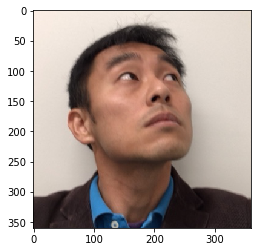

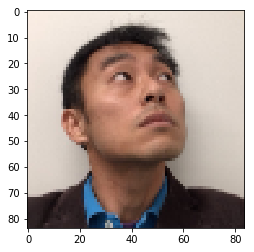

(1, 3, 84, 84)


In [13]:
im = im_true.astype(np.float32)/255 # Normalized

crop_uly = 62
crop_height = 360
crop_ulx = 100
crop_width = 360

im = im[crop_uly:crop_uly + crop_height, crop_ulx:crop_ulx + crop_width]
im_crop = im
plt.imshow(im_crop[:,:,::-1])
plt.show()

im = cv2.resize(im, (84, 84))
plt.imshow(im[:,:,::-1])
plt.show()

im = np.swapaxes(im, 0, 2)
im = np.swapaxes(im, 1, 2)
im = im[np.newaxis, :]
im = (im) * 255
print(im.shape)

Now we can use the ``predictor`` object to classify the head pose:

In [14]:
data = im

prob = predictor.predict(data)
print('Raw prediction result:')
print(prob)

labeled_predictions = list(zip(range(10), prob[0]))
print('Labeled predictions: ')
print(labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print('Most likely answer: {}'.format(labeled_predictions[0]))

Raw prediction result:
[[1.9550670913304202e-06, 0.00043171478318981826, 0.9981489181518555, 1.2677614336098486e-07, 6.118108331065741e-07, 0.0012495489791035652, 1.5982056993379956e-06, 2.2388953766494524e-06, 0.0001633479114389047]]
Labeled predictions: 
[(0, 1.9550670913304202e-06), (1, 0.00043171478318981826), (2, 0.9981489181518555), (3, 1.2677614336098486e-07), (4, 6.118108331065741e-07), (5, 0.0012495489791035652), (6, 1.5982056993379956e-06), (7, 2.2388953766494524e-06), (8, 0.0001633479114389047)]
Most likely answer: (2, 0.9981489181518555)


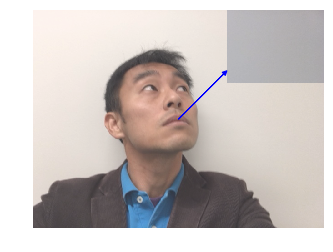

In [15]:
n_grid_cls = 9
n_tilt_cls = 3

pred = labeled_predictions[0][0]


### Tilt Prediction
pred_tilt_pic = pred % n_tilt_cls
### Pan Prediction
pred_pan_pic = pred // n_tilt_cls

extent = 0, im_true.shape[1]-1, im_true.shape[0]-1, 0
Panel_Pred = np.zeros((n_tilt_cls, n_tilt_cls))
Panel_Pred[pred_tilt_pic, pred_pan_pic] = 1
Panel_Pred = np.fliplr(Panel_Pred)
Panel_Pred = np.flipud(Panel_Pred)
plt.imshow(im_true[:,:,[2,1,0]], extent=extent)
plt.imshow(Panel_Pred, cmap=plt.cm.Blues, alpha=.2, interpolation='nearest', extent=extent)
plt.axis('off')
arrw_mg = 100
arrw_x_rad = 1 * (prob[0][0] + prob[0][1] + prob[0][2] - prob[0][6] -prob[0][7] - prob[0][8]) * 90 * np.pi / 180. 
arrw_y_rad = 1 * (prob[0][0] + prob[0][3] + prob[0][6] - prob[0][2] -prob[0][5] - prob[0][8]) * 90 * np.pi / 180.

plt.arrow(im_true.shape[1]//2, im_true.shape[0]//2, 
          np.sin(arrw_x_rad) * arrw_mg, np.sin(arrw_y_rad) * arrw_mg, 
          head_width=10, head_length=10, fc='b', ec='b')
plt.show()

# (Optional) Delete the Endpoint

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [16]:
print("Endpoint name: " + predictor.endpoint)

Endpoint name: sagemaker-mxnet-py2-cpu-2018-02-12-23-53-18-244


In [17]:
import sagemaker

sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-py2-cpu-2018-02-12-23-53-18-244


# End